In [5]:
import numpy as np
import seaborn as sns;
from matplotlib import pyplot as plt
import itertools
import keras

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs

In [6]:
cd /Users/William/Documents/GitHub/progressive-learning

/Users/William/Documents/GitHub/progressive-learning


In [7]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

In [8]:
def cross_val_data(data_x, data_y, num_points_per_task, total_task=10, shift=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]

    batch_per_task=5000//num_points_per_task
    sample_per_class = num_points_per_task//total_task

    for task in range(total_task):
        for batch in range(batch_per_task):
            for class_no in range(task*10,(task+1)*10,1):
                indx = np.roll(idx[class_no],(shift-1)*100)

                if batch==0 and class_no==0 and task==0:
                    train_x = x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]
                    test_x = x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]
                    train_y = np.random.randint(low = 0, high = total_task, size = sample_per_class)
                    test_y = np.random.randint(low = 0, high = total_task, size = total_task)
                else:
                    train_x = np.concatenate((train_x, x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                    test_x = np.concatenate((test_x, x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    if task == 0:
                        train_y = np.concatenate((train_y, y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                        test_y = np.concatenate((test_y, y[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    else:
                        train_y = np.concatenate((train_y, np.random.randint(low = 0, high = total_task, size = sample_per_class)), axis=0)
                        test_y = np.concatenate((test_y, np.random.randint(low = 0, high = total_task, size = total_task)), axis = 0)

    return train_x, train_y, test_x, test_y



def split(data_x, data_y, classes=[0,1,2]):
    x = data_x.copy()
    y = data_y.copy()
    i = np.array([np.where(data_y == u)[0] for u in classes]).ravel()
    
    return x[i,:], y[i]



def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R



def generate_gaussian_parity(n_samples, centers=None, class_label=None,
    cluster_std=0.25, angle_params=None, random_state=None):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

# XOR to R_XOR

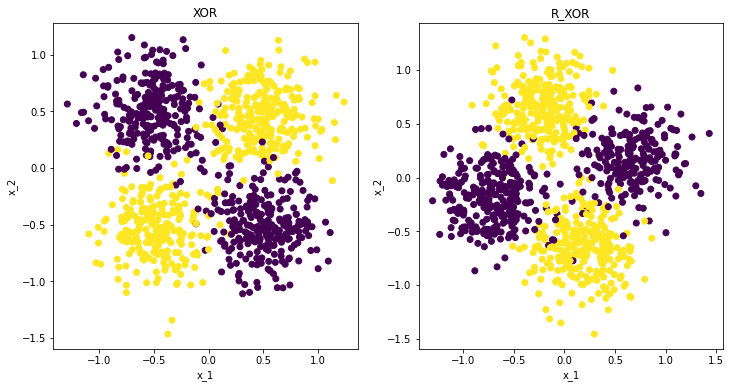

In [12]:
#Make XOR and R_XOR
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, angle_params=np.pi/3)

#Plot XOR
plt.figure(figsize=(12,6));
plt.subplot(121)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title('XOR');
plt.xlabel("x_1"); plt.ylabel("x_2");

#Plot for R_XOR
plt.subplot(122)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title('R_XOR');
plt.xlabel("x_1"); plt.ylabel("x_2");

In [16]:
#Registration
template = np.c_[X1, y1]
target = np.c_[X2, y2]

df_reg = DeformableRegistration(X=target, Y=template, max_iterations=20)
deformed_template = df_reg.register(template)

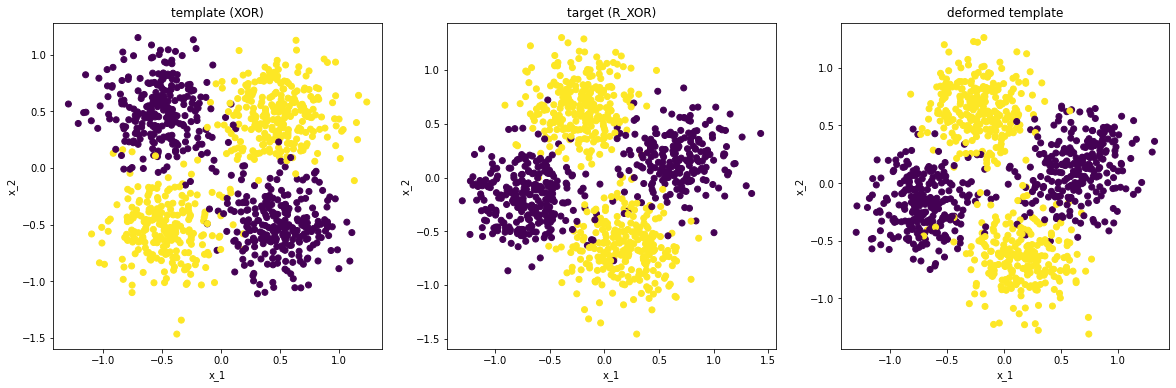

In [17]:
#plot
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("template (XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");


plt.subplot(132)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("target (R_XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");

z = deformed_template[0]
plt.subplot(133)
plt.scatter(z[:,0], z[:,1], c=z[:,2])
plt.title("deformed template")
plt.xlabel("x_1"); plt.ylabel("x_2");

# CIFAR

In [18]:
#data setup
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

data_x = np.concatenate([X_train, X_test])
data_x = data_x[:,:,:,0]
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2]))
#data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

x_task1, y_task1 = split(data_x, data_y, classes=[0,1])
x_task2, y_task2 = split(data_x, data_y, classes=[2,3])

#random sample
np.random.seed(10)
sample1 = np.random.uniform(size = len(x_task1)) < 0.01
sample2 = np.random.uniform(size = len(x_task2)) < 0.01
x_task1 = x_task1[sample1]
y_task1 = y_task1[sample1]
x_task2 = x_task2[sample2]
y_task2 = y_task2[sample2]

Text(0.5, 1.0, 'Task 2')

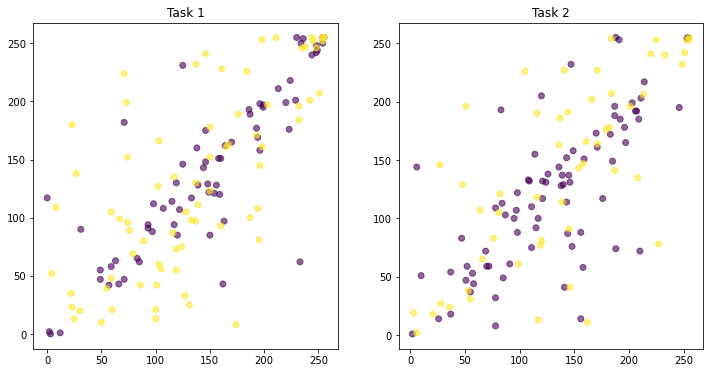

In [19]:
#random look at data
a, b = np.random.randint(0,1024, 2)

plt.figure(figsize=(12,6));
plt.subplot(121)
plt.scatter(x_task1[:,a], x_task1[:,b], c=y_task1, alpha=0.6)
plt.title('Task 1')
plt.subplot(122)
plt.scatter(x_task2[:,a], x_task2[:,b], c=y_task2, alpha=0.6)
plt.title('Task 2')

In [20]:
#Registration
template = np.c_[x_task1, y_task1]
target = np.c_[x_task2, y_task2]

df_reg = DeformableRegistration(X=target, Y=template, max_iterations=2)
deformed_template = df_reg.register(template)

/Users/William/anaconda3/envs/ndd/lib/python3.7/site-packages/pycpd/emregistration.py:165: RuntimeWarning: overflow encountered in double_scalars
  c = (2 * np.pi * self.sigma2) ** (self.D / 2)
/Users/William/anaconda3/envs/ndd/lib/python3.7/site-packages/pycpd/emregistration.py:166: RuntimeWarning: invalid value encountered in double_scalars
  c = c * self.w / (1 - self.w)
